# Week 2: Day 4-5 Baseline Model Training

---

## 📋 Overview

Train and evaluate regression models for music emotion recognition.

### 🎯 Objectives
- Predict Valence and Arousal using 133-dimensional audio features
- Compare different models and feature selection strategies
- Analyze feature importance

### 📊 Data
- **Input**: `deam_features_all.csv` (1,802 songs × 133 features)
- **Targets**: Valence (pleasantness), Arousal (activation)
- **Range**: 1-9 continuous values

### 🤖 Models
1. **Linear Regression** (baseline) - with feature selection
2. **Random Forest** (advanced) - with all features

### 📈 Evaluation Metrics
- **MSE** (Mean Squared Error) - lower is better
- **RMSE** (Root MSE) - same unit as target
- **R²** (Coefficient of Determination) - 0-1, higher is better
- **MAE** (Mean Absolute Error) - average error
- **NRMSE** (Normalized RMSE) - RMSE / range

---


## 1. Import Libraries and Setup


In [1]:
# Data processing
import pandas as pd
import numpy as np
from pathlib import Path

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print(f"Random seed: {RANDOM_STATE}")


Random seed: 42


## 2. Load Data


In [3]:
# Set paths
# Note: English notebooks are in notebooks_en/ subdirectory
BASE_DIR = Path('../..')  # Go up two levels: notebooks_en/ -> notebooks/ -> Semester1/
DATA_DIR = BASE_DIR / 'data' / 'DEAM' / 'processed'
OUTPUT_DIR = BASE_DIR / 'models'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load feature data
df = pd.read_csv(DATA_DIR / 'deam_features_all.csv')

print("=" * 60)
print("Data loaded successfully")
print("=" * 60)
print(f"Data shape: {df.shape}")
print(f"Number of songs: {len(df)}")
print(f"Total features: {len(df.columns) - 3} (excluding song_id, valence, arousal)")

# Check data
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nTarget variable statistics:")
print(df[['valence', 'arousal']].describe())

# Display first rows
print(f"\nData preview:")
df.head(3)


Data loaded successfully
Data shape: (1802, 136)
Number of songs: 1802
Total features: 133 (excluding song_id, valence, arousal)

Missing values: 0

Target variable statistics:
           valence      arousal
count  1802.000000  1802.000000
mean      4.904145     4.814029
std       1.174240     1.282187
min       1.600000     1.600000
25%       4.100000     3.800000
50%       4.900000     4.900000
75%       5.800000     5.800000
max       8.400000     8.100000

Data preview:


,song_id,valence,arousal,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,spectral_contrast_std_4,spectral_contrast_std_5,spectral_contrast_std_6,spectral_bandwidth_mean,spectral_bandwidth_std,zcr_mean,zcr_std,tempo,beat_count,beat_strength
0,10,4.0,4.7,-267.085083,127.493530,8.400689,20.838123,22.413507,4.686923,3.501557,...,5.750051,5.283269,3.250004,1948.064551,845.873880,0.076029,0.044954,95.703125,69,8.759209
1,1000,6.8,5.6,-29.007280,102.692879,-6.246353,28.312904,4.621873,13.930796,-1.978068,...,2.884433,3.147916,4.423245,2349.332390,461.912564,0.092049,0.043951,135.999178,102,4.009600
2,1001,4.4,3.8,-164.742874,125.447189,-19.984291,19.461418,3.997231,3.891716,-2.401595,...,3.118613,3.924159,3.153705,2006.712984,503.901749,0.094551,0.038888,117.453835,84,3.427346


## 3. Feature Selection Strategy

Based on Day 3 correlation analysis, we implement two strategies:

### Strategy Comparison

| Strategy | Model | # Features | Reason |
|----------|-------|------------|--------|
| **Strategy A: Feature Selection** | Linear Regression | ~129 | Reduce multicollinearity |
| **Strategy B: Keep All** | Random Forest | 133 | Tree models handle multicollinearity |

### Selection Rules (Strategy A)

1. ✅ **Keep**: `mfcc_mean_0` (most important feature r=0.59)
2. ❌ **Remove**: `spectral_rolloff`, `spectral_bandwidth` (redundant with centroid r>0.89)
3. ✅ **Keep**: `spectral_centroid` (representative of spectral group)
4. ✅ **Keep**: All Chroma and Spectral Contrast features
5. ✅ **Keep**: Rhythm features (`tempo`, `beat_strength`)


In [4]:
# Separate features and targets
X_all = df.drop(['song_id', 'valence', 'arousal'], axis=1)
y_valence = df['valence']
y_arousal = df['arousal']

print("=" * 60)
print("Feature Selection")
print("=" * 60)

# Strategy A: Feature selection (for linear regression)
# Remove highly redundant features
features_to_remove = [
    'spectral_rolloff_mean', 'spectral_rolloff_std',      # Redundant with centroid (r=0.98)
    'spectral_bandwidth_mean', 'spectral_bandwidth_std',  # Redundant with centroid (r=0.89)
]

# Create selected feature set
X_selected = X_all.drop(columns=features_to_remove)

print(f"\nStrategy A - Feature Selection (for Linear Regression):")
print(f"  • Original features: {X_all.shape[1]}")
print(f"  • Removed features: {len(features_to_remove)}")
print(f"  • Retained features: {X_selected.shape[1]}")
print(f"  • Features removed: {features_to_remove}")

print(f"\nStrategy B - Keep All (for Random Forest):")
print(f"  • Features: {X_all.shape[1]}")
print(f"  • Strategy: Let model handle multicollinearity")

# Save feature names
feature_names_selected = X_selected.columns.tolist()
feature_names_all = X_all.columns.tolist()


Feature Selection

Strategy A - Feature Selection (for Linear Regression):
  • Original features: 133
  • Removed features: 4
  • Retained features: 129
  • Features removed: ['spectral_rolloff_mean', 'spectral_rolloff_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std']

Strategy B - Keep All (for Random Forest):
  • Features: 133
  • Strategy: Let model handle multicollinearity


## 4. Data Splitting

### Split Strategy
- **Training set**: 70% (~1,261 songs)
- **Validation set**: 15% (~271 songs)
- **Test set**: 15% (~270 songs)

### Why three sets?
- **Training set**: For model learning
- **Validation set**: For hyperparameter tuning and model selection
- **Test set**: For final evaluation (model never sees this)


In [5]:
def split_data(X, y_val, y_aro, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into train/validation/test sets
    
    Parameters:
        X: Feature matrix
        y_val: Valence target
        y_aro: Arousal target
        test_size: Test set proportion
        val_size: Validation set proportion (relative to remaining data)
        random_state: Random seed
    
    Returns:
        Dictionary containing all split data
    """
    # First split: separate test set
    X_temp, X_test, y_val_temp, y_val_test, y_aro_temp, y_aro_test = train_test_split(
        X, y_val, y_aro, test_size=test_size, random_state=random_state
    )
    
    # Second split: separate validation set from remaining data
    X_train, X_val, y_val_train, y_val_val, y_aro_train, y_aro_val = train_test_split(
        X_temp, y_val_temp, y_aro_temp, test_size=val_size/(1-test_size), random_state=random_state
    )
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_val_train': y_val_train, 'y_val_val': y_val_val, 'y_val_test': y_val_test,
        'y_aro_train': y_aro_train, 'y_aro_val': y_aro_val, 'y_aro_test': y_aro_test
    }


In [6]:
print("=" * 60)
print("Data Splitting")
print("=" * 60)

# Strategy A: Selected features
data_selected = split_data(X_selected, y_valence, y_arousal)

# Strategy B: All features
data_all = split_data(X_all, y_valence, y_arousal)

print(f"\nDataset sizes:")
print(f"  Training: {len(data_selected['X_train'])} songs ({len(data_selected['X_train'])/len(df)*100:.1f}%)")
print(f"  Validation: {len(data_selected['X_val'])} songs ({len(data_selected['X_val'])/len(df)*100:.1f}%)")
print(f"  Test: {len(data_selected['X_test'])} songs ({len(data_selected['X_test'])/len(df)*100:.1f}%)")
print(f"  Total: {len(df)} songs")


Data Splitting

Dataset sizes:
  Training: 1260 songs (69.9%)
  Validation: 271 songs (15.0%)
  Test: 271 songs (15.0%)
  Total: 1802 songs


## 5. Feature Standardization

### Why standardization?
- Different features have different scales (e.g., tempo ~120, mfcc_mean_0 ~-150)
- Linear regression is scale-sensitive
- After standardization, all features have mean=0, std=1

### ⚠️ Important Rule
- **Only fit Scaler on training set** - avoid data leakage
- **Use same parameters to transform validation and test sets**


In [7]:
def standardize_features(data_dict):
    """
    Standardize features (fit only on training set)
    
    Parameters:
        data_dict: Dictionary containing X_train, X_val, X_test
    
    Returns:
        Standardized data dictionary and scaler object
    """
    scaler = StandardScaler()
    
    # Fit only on training set
    scaler.fit(data_dict['X_train'])
    
    # Transform all sets
    data_dict['X_train_scaled'] = scaler.transform(data_dict['X_train'])
    data_dict['X_val_scaled'] = scaler.transform(data_dict['X_val'])
    data_dict['X_test_scaled'] = scaler.transform(data_dict['X_test'])
    
    return data_dict, scaler


In [8]:
print("=" * 60)
print("Feature Standardization")
print("=" * 60)

# Standardize both strategies
data_selected, scaler_selected = standardize_features(data_selected)
data_all, scaler_all = standardize_features(data_all)

# Verify standardization
print(f"\nBefore standardization (Training set):") 
print(f"  Mean: {data_selected['X_train'].mean(axis=0)[:3].values}...")
print(f"  Std: {data_selected['X_train'].std(axis=0)[:3].values}...")

print(f"\nAfter standardization (Training set):")
print(f"  Mean: {data_selected['X_train_scaled'].mean(axis=0)[:3]}...")
print(f"  Std: {data_selected['X_train_scaled'].std(axis=0)[:3]}...")


Feature Standardization

Before standardization (Training set):
  Mean: [-182.17885753  117.8123996    -2.37271063]...
  Std: [89.06073783 37.33572998 26.619619  ]...

After standardization (Training set):
  Mean: [ 7.89491929e-17  1.50849351e-16 -2.18520087e-17]...
  Std: [1. 1. 1.]...


## 6. Model Training

### Model Comparison

| Model | Feature Strategy | Advantages | Disadvantages |
|-------|------------------|------------|---------------|
| **Linear Regression** | Selected features | Simple, interpretable | Only linear relationships |
| **Random Forest** | All features | Captures nonlinearity, feature importance | Black box, slower |

### Training Strategy
- Train separate models for Valence and Arousal
- Fit on training set
- Evaluate on validation set


### 6.1 Linear Regression (Baseline Model)


In [9]:
print("=" * 60)
print("Training Linear Regression models")
print("=" * 60)

# Create models
lr_valence = LinearRegression()
lr_arousal = LinearRegression()

# Train Valence model
lr_valence.fit(data_selected['X_train_scaled'], data_selected['y_val_train'])

# Train Arousal model
lr_arousal.fit(data_selected['X_train_scaled'], data_selected['y_aro_train'])

# Predictions
lr_val_train_pred = lr_valence.predict(data_selected['X_train_scaled'])
lr_val_val_pred = lr_valence.predict(data_selected['X_val_scaled'])

lr_aro_train_pred = lr_arousal.predict(data_selected['X_train_scaled'])
lr_aro_val_pred = lr_arousal.predict(data_selected['X_val_scaled'])


Training Linear Regression models


### 6.2 Random Forest (Advanced Model)


In [10]:
print("=" * 60)
print("Training Random Forest models")
print("=" * 60)

# Create models
rf_valence = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=20,          # Maximum depth
    min_samples_split=5,   # Minimum samples to split
    min_samples_leaf=2,    # Minimum samples per leaf
    random_state=RANDOM_STATE,
    n_jobs=-1              # Use all CPU cores
)

rf_arousal = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train Valence model
rf_valence.fit(data_all['X_train_scaled'], data_all['y_val_train'])

# Train Arousal model
rf_arousal.fit(data_all['X_train_scaled'], data_all['y_aro_train'])

# Predictions
rf_val_train_pred = rf_valence.predict(data_all['X_train_scaled'])
rf_val_val_pred = rf_valence.predict(data_all['X_val_scaled'])

rf_aro_train_pred = rf_arousal.predict(data_all['X_train_scaled'])
rf_aro_val_pred = rf_arousal.predict(data_all['X_val_scaled'])


Training Random Forest models


In [11]:
# Define evaluation functions

# Define data ranges (for NRMSE calculation)
VALENCE_RANGE = 8.4 - 1.6  # 6.8
AROUSAL_RANGE = 8.1 - 1.6  # 6.5

def evaluate_model(y_true, y_pred, dataset_name="", target_range=None):
    """
    Calculate regression model evaluation metrics
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted values
    dataset_name : str
        Dataset name (Train/Validation/Test)
    target_range : float, optional
        Target variable range (max - min), for NRMSE calculation
        If None, NRMSE is not calculated
    
    Returns:
    --------
    dict : Dictionary containing MSE, RMSE, MAE, R², NRMSE
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    result = {
        'dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    # Calculate NRMSE (Normalized RMSE)
    if target_range is not None and target_range > 0:
        nrmse = rmse / target_range
        result['NRMSE'] = nrmse
    
    return result

def print_evaluation(results_dict, title=""):
    """Print evaluation results"""
    if isinstance(results_dict, dict):
        results_dict = [results_dict]
        
    if title:
        print(f"\n{title}")
    print("-" * 80)
    
    # Check if NRMSE is included
    has_nrmse = 'NRMSE' in results_dict[0] if results_dict else False
    
    if has_nrmse:
        print(f"{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'NRMSE':>10}")
    else:
        print(f"{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    
    print("-" * 80)
    
    for result in results_dict:
        if has_nrmse:
            print(f"{result['dataset']:<15} "
                  f"{result['MSE']:>10.4f} "
                  f"{result['RMSE']:>10.4f} "
                  f"{result['MAE']:>10.4f} "
                  f"{result['R²']:>10.4f} "
                  f"{result['NRMSE']:>10.4f}")
        else:
            print(f"{result['dataset']:<15} "
                  f"{result['MSE']:>10.4f} "
                  f"{result['RMSE']:>10.4f} "
                  f"{result['MAE']:>10.4f} "
                  f"{result['R²']:>10.4f}")
    
    print("-" * 80)

print(f"Valence range: 1.6 - 8.4 (Δ = {VALENCE_RANGE:.1f})")
print(f"Arousal range: 1.6 - 8.1 (Δ = {AROUSAL_RANGE:.1f})")


Valence range: 1.6 - 8.4 (Δ = 6.8)
Arousal range: 1.6 - 8.1 (Δ = 6.5)


In [12]:
## 6.3 Additional Models (Ridge / Lasso / ElasticNet / SVR)

print("=" * 60)
print("Training additional models (using selected & standardized features)")
print("=" * 60)

# Use same features and standardization as linear regression (data_selected)
Xtr = data_selected['X_train_scaled']
Xval = data_selected['X_val_scaled']

# Valence models
ridge_val = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_val.fit(Xtr, data_selected['y_val_train'])
ridge_val_train_pred = ridge_val.predict(Xtr)
ridge_val_val_pred = ridge_val.predict(Xval)

lasso_val = Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)
lasso_val.fit(Xtr, data_selected['y_val_train'])
lasso_val_train_pred = lasso_val.predict(Xtr)
lasso_val_val_pred = lasso_val.predict(Xval)

enet_val = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_STATE)
enet_val.fit(Xtr, data_selected['y_val_train'])
enet_val_train_pred = enet_val.predict(Xtr)
enet_val_val_pred = enet_val.predict(Xval)

svr_val = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
svr_val.fit(Xtr, data_selected['y_val_train'])
svr_val_train_pred = svr_val.predict(Xtr)
svr_val_val_pred = svr_val.predict(Xval)

ridge_val_results = [
    evaluate_model(data_selected['y_val_train'], ridge_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_selected['y_val_val'], ridge_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
lasso_val_results = [
    evaluate_model(data_selected['y_val_train'], lasso_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_selected['y_val_val'], lasso_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
enet_val_results = [
    evaluate_model(data_selected['y_val_train'], enet_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_selected['y_val_val'], enet_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
svr_val_results = [
    evaluate_model(data_selected['y_val_train'], svr_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_selected['y_val_val'], svr_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]

print_evaluation(ridge_val_results, "Ridge - Valence")
print_evaluation(lasso_val_results, "Lasso - Valence")
print_evaluation(enet_val_results,  "ElasticNet - Valence")
print_evaluation(svr_val_results,   "SVR (RBF) - Valence")

# Arousal models
ridge_aro = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_aro.fit(Xtr, data_selected['y_aro_train'])
ridge_aro_train_pred = ridge_aro.predict(Xtr)
ridge_aro_val_pred = ridge_aro.predict(Xval)

lasso_aro = Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)
lasso_aro.fit(Xtr, data_selected['y_aro_train'])
lasso_aro_train_pred = lasso_aro.predict(Xtr)
lasso_aro_val_pred = lasso_aro.predict(Xval)

enet_aro = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_STATE)
enet_aro.fit(Xtr, data_selected['y_aro_train'])
enet_aro_train_pred = enet_aro.predict(Xtr)
enet_aro_val_pred = enet_aro.predict(Xval)

svr_aro = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
svr_aro.fit(Xtr, data_selected['y_aro_train'])
svr_aro_train_pred = svr_aro.predict(Xtr)
svr_aro_val_pred = svr_aro.predict(Xval)

ridge_aro_results = [
    evaluate_model(data_selected['y_aro_train'], ridge_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_selected['y_aro_val'], ridge_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
lasso_aro_results = [
    evaluate_model(data_selected['y_aro_train'], lasso_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_selected['y_aro_val'], lasso_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
enet_aro_results = [
    evaluate_model(data_selected['y_aro_train'], enet_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_selected['y_aro_val'], enet_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
svr_aro_results = [
    evaluate_model(data_selected['y_aro_train'], svr_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_selected['y_aro_val'], svr_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]

print_evaluation(ridge_aro_results, "Ridge - Arousal")
print_evaluation(lasso_aro_results, "Lasso - Arousal")
print_evaluation(enet_aro_results,  "ElasticNet - Arousal")
print_evaluation(svr_aro_results,   "SVR (RBF) - Arousal")


Training additional models (using selected & standardized features)

Ridge - Valence
--------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
--------------------------------------------------------------------------------
Train               0.6164     0.7851     0.6248     0.5396     0.1155
Validation          0.7250     0.8515     0.6875     0.4587     0.1252
--------------------------------------------------------------------------------

Lasso - Valence
--------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
--------------------------------------------------------------------------------
Train               0.6175     0.7858     0.6257     0.5387     0.1156
Validation          0.7156     0.8460     0.6827     0.4657     0.1244
-------------------------------------------------------------------

## 7. Model Evaluation

### Evaluation Metrics

| Metric | Formula | Interpretation | Optimal Value |
|--------|---------|----------------|---------------|
| **MSE** | $\frac{1}{n}\sum(y-\hat{y})^2$ | Mean squared error | 0 |
| **RMSE** | $\sqrt{MSE}$ | Same unit as target | 0 |
| **MAE** | $\frac{1}{n}\sum\|y-\hat{y}\|$ | Mean absolute error | 0 |
| **R²** | $1-\frac{SS_{res}}{SS_{tot}}$ | Explained variance ratio | 1 |
| **NRMSE** ✨ | $\frac{RMSE}{y_{max} - y_{min}}$ | Normalized RMSE | 0 |

**✨ NRMSE (Normalized RMSE)**
- **Formula**: NRMSE = RMSE / (max - min)
- **Purpose**: Provides more intuitive error interpretation (percentage of data range)
- **Example**: If RMSE = 0.85, data range = 6.8, then NRMSE = 0.125 (12.5%)
- **DEAM data ranges**: 
  - Valence: 1.6 - 8.4 (Δ = 6.8)
  - Arousal: 1.6 - 8.1 (Δ = 6.5)


In [13]:
print("=" * 60)
print("Model Evaluation")
print("=" * 60)

# Linear Regression - Valence
lr_val_results = [
    evaluate_model(data_selected['y_val_train'], lr_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_selected['y_val_val'], lr_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
print_evaluation(lr_val_results, "Linear Regression - Valence")

# Linear Regression - Arousal
lr_aro_results = [
    evaluate_model(data_selected['y_aro_train'], lr_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_selected['y_aro_val'], lr_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
print_evaluation(lr_aro_results, "Linear Regression - Arousal")

# Random Forest - Valence
rf_val_results = [
    evaluate_model(data_all['y_val_train'], rf_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(data_all['y_val_val'], rf_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
print_evaluation(rf_val_results, "Random Forest - Valence")

# Random Forest - Arousal
rf_aro_results = [
    evaluate_model(data_all['y_aro_train'], rf_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(data_all['y_aro_val'], rf_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
print_evaluation(rf_aro_results, "Random Forest - Arousal")


Model Evaluation

Linear Regression - Valence
--------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
--------------------------------------------------------------------------------
Train               0.6164     0.7851     0.6248     0.5396     0.1155
Validation          0.7260     0.8521     0.6881     0.4580     0.1253
--------------------------------------------------------------------------------

Linear Regression - Arousal
--------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
--------------------------------------------------------------------------------
Train               0.7481     0.8649     0.6825     0.5430     0.1331
Validation          0.7915     0.8896     0.7056     0.4985     0.1369
--------------------------------------------------------------------------------

Random Fores

### 7.1 Evaluation Results Comparison


In [14]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': 'Linear Regression',
        'Target': 'Valence',
        'Train R²': lr_val_results[0]['R²'],
        'Val R²': lr_val_results[1]['R²'],
        'Val RMSE': lr_val_results[1]['RMSE'],
        'Val NRMSE': lr_val_results[1]['NRMSE'],
        'Val MAE': lr_val_results[1]['MAE']
    },
    {
        'Model': 'Linear Regression',
        'Target': 'Arousal',
        'Train R²': lr_aro_results[0]['R²'],
        'Val R²': lr_aro_results[1]['R²'],
        'Val RMSE': lr_aro_results[1]['RMSE'],
        'Val NRMSE': lr_aro_results[1]['NRMSE'],
        'Val MAE': lr_aro_results[1]['MAE']
    },
    {
        'Model': 'Random Forest',
        'Target': 'Valence',
        'Train R²': rf_val_results[0]['R²'],
        'Val R²': rf_val_results[1]['R²'],
        'Val RMSE': rf_val_results[1]['RMSE'],
        'Val NRMSE': rf_val_results[1]['NRMSE'],
        'Val MAE': rf_val_results[1]['MAE']
    },
    {
        'Model': 'Random Forest',
        'Target': 'Arousal',
        'Train R²': rf_aro_results[0]['R²'],
        'Val R²': rf_aro_results[1]['R²'],
        'Val RMSE': rf_aro_results[1]['RMSE'],
        'Val NRMSE': rf_aro_results[1]['NRMSE'],
        'Val MAE': rf_aro_results[1]['MAE']
    }
])

print("\n" + "=" * 80)
print("Model Performance Comparison (Validation Set) - with NRMSE")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Find best Valence model
valence_df = comparison_df[comparison_df['Target'] == 'Valence']
best_val_idx = valence_df['Val R²'].idxmax()
best_val_model = valence_df.loc[best_val_idx]

print(f"\nBest Valence model: {best_val_model['Model']}")
print(f"   • R² = {best_val_model['Val R²']:.4f}")
print(f"   • RMSE = {best_val_model['Val RMSE']:.4f}")
print(f"   • NRMSE = {best_val_model['Val NRMSE']:.4f} ({best_val_model['Val NRMSE']*100:.2f}%)")

# Find best Arousal model
arousal_df = comparison_df[comparison_df['Target'] == 'Arousal']
best_aro_idx = arousal_df['Val R²'].idxmax()
best_aro_model = arousal_df.loc[best_aro_idx]

print(f"\nBest Arousal model: {best_aro_model['Model']}")
print(f"   • R² = {best_aro_model['Val R²']:.4f}")
print(f"   • RMSE = {best_aro_model['Val RMSE']:.4f}")
print(f"   • NRMSE = {best_aro_model['Val NRMSE']:.4f} ({best_aro_model['Val NRMSE']*100:.2f}%)")



Model Performance Comparison (Validation Set) - with NRMSE
            Model  Target  Train R²   Val R²  Val RMSE  Val NRMSE  Val MAE
Linear Regression Valence  0.539575 0.457966  0.852077   0.125306 0.688118
Linear Regression Arousal  0.543047 0.498474  0.889647   0.136869 0.705608
    Random Forest Valence  0.909046 0.488715  0.827556   0.121699 0.670455
    Random Forest Arousal  0.912198 0.530939  0.860371   0.132365 0.672311

Best Valence model: Random Forest
   • R² = 0.4887
   • RMSE = 0.8276
   • NRMSE = 0.1217 (12.17%)

Best Arousal model: Random Forest
   • R² = 0.5309
   • RMSE = 0.8604
   • NRMSE = 0.1324 (13.24%)


## 8. Visualize Prediction Results


### 8.1 True vs Predicted Scatter Plots


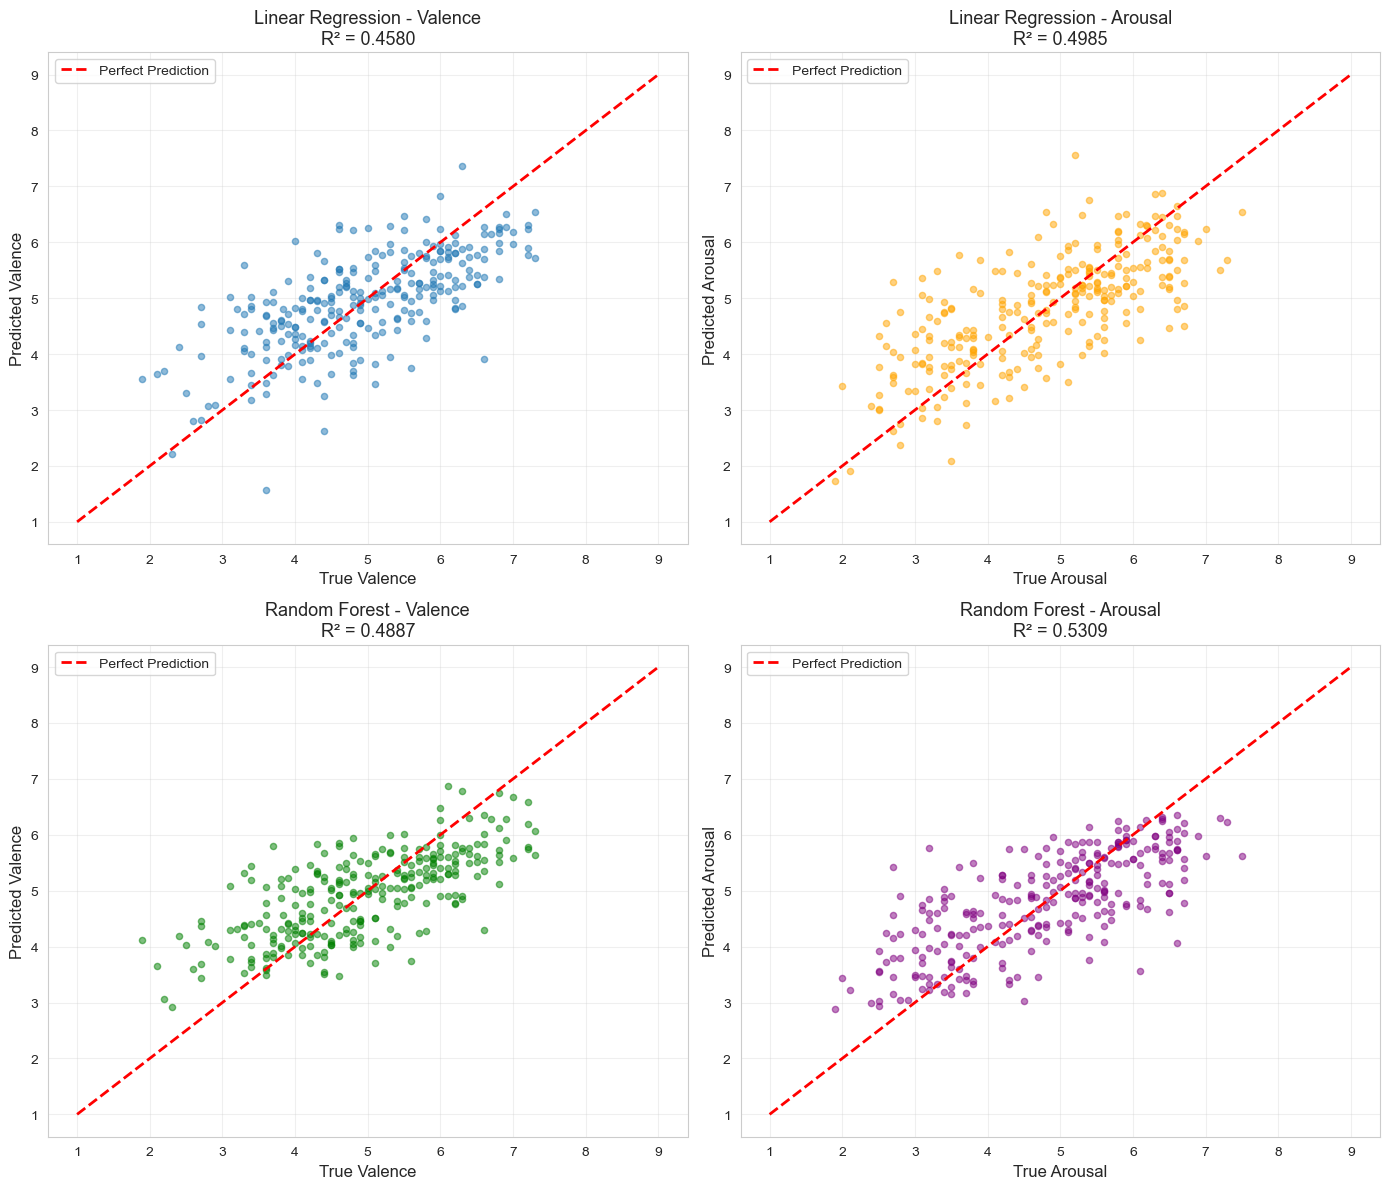

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Linear Regression - Valence
axes[0, 0].scatter(data_selected['y_val_val'], lr_val_val_pred, alpha=0.5, s=20)
axes[0, 0].plot([1, 9], [1, 9], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('True Valence', fontsize=12)
axes[0, 0].set_ylabel('Predicted Valence', fontsize=12)
axes[0, 0].set_title(f'Linear Regression - Valence\nR² = {lr_val_results[1]["R²"]:.4f}', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Linear Regression - Arousal
axes[0, 1].scatter(data_selected['y_aro_val'], lr_aro_val_pred, alpha=0.5, s=20, color='orange')
axes[0, 1].plot([1, 9], [1, 9], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('True Arousal', fontsize=12)
axes[0, 1].set_ylabel('Predicted Arousal', fontsize=12)
axes[0, 1].set_title(f'Linear Regression - Arousal\nR² = {lr_aro_results[1]["R²"]:.4f}', fontsize=13)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Random Forest - Valence
axes[1, 0].scatter(data_all['y_val_val'], rf_val_val_pred, alpha=0.5, s=20, color='green')
axes[1, 0].plot([1, 9], [1, 9], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('True Valence', fontsize=12)
axes[1, 0].set_ylabel('Predicted Valence', fontsize=12)
axes[1, 0].set_title(f'Random Forest - Valence\nR² = {rf_val_results[1]["R²"]:.4f}', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Random Forest - Arousal
axes[1, 1].scatter(data_all['y_aro_val'], rf_aro_val_pred, alpha=0.5, s=20, color='purple')
axes[1, 1].plot([1, 9], [1, 9], 'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('True Arousal', fontsize=12)
axes[1, 1].set_ylabel('Predicted Arousal', fontsize=12)
axes[1, 1].set_title(f'Random Forest - Arousal\nR² = {rf_aro_results[1]["R²"]:.4f}', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prediction_scatter.png', dpi=150, bbox_inches='tight')
plt.show()


### 8.2 Residual Distribution

Residual = True value - Predicted value

Ideally, residuals should:
- Have mean close to 0 (unbiased prediction)
- Follow normal distribution (random errors)


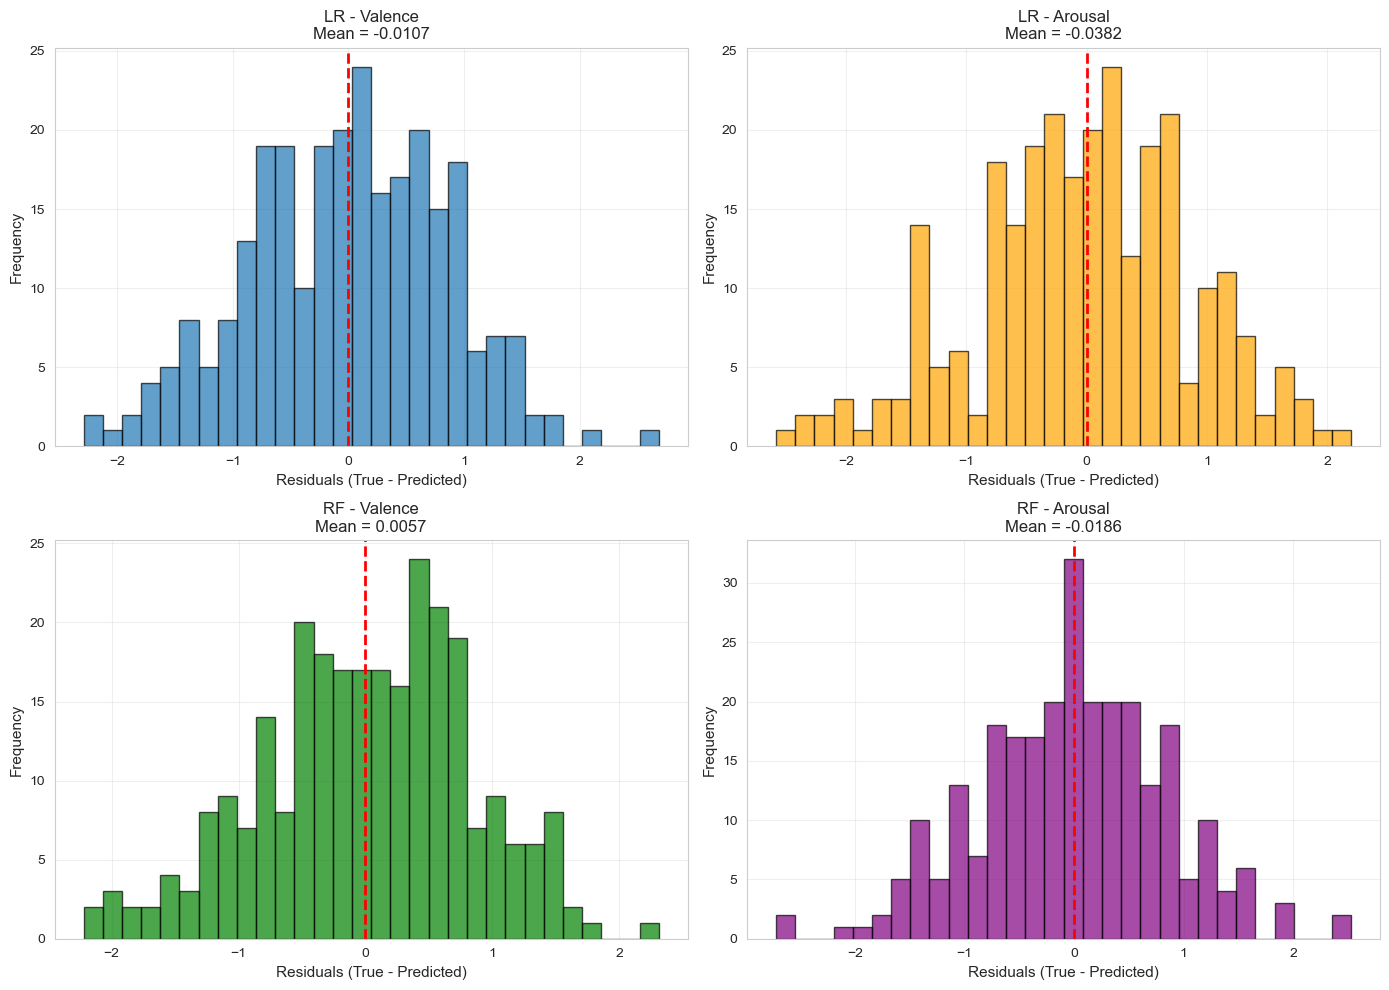

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate residuals
lr_val_residuals = data_selected['y_val_val'] - lr_val_val_pred
lr_aro_residuals = data_selected['y_aro_val'] - lr_aro_val_pred
rf_val_residuals = data_all['y_val_val'] - rf_val_val_pred
rf_aro_residuals = data_all['y_aro_val'] - rf_aro_val_pred

# Linear Regression - Valence
axes[0, 0].hist(lr_val_residuals, bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Residuals (True - Predicted)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title(f'LR - Valence\nMean = {lr_val_residuals.mean():.4f}', fontsize=12)
axes[0, 0].grid(alpha=0.3)

# Linear Regression - Arousal
axes[0, 1].hist(lr_aro_residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (True - Predicted)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title(f'LR - Arousal\nMean = {lr_aro_residuals.mean():.4f}', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Random Forest - Valence
axes[1, 0].hist(rf_val_residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (True - Predicted)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title(f'RF - Valence\nMean = {rf_val_residuals.mean():.4f}', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# Random Forest - Arousal
axes[1, 1].hist(rf_aro_residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (True - Predicted)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title(f'RF - Arousal\nMean = {rf_aro_residuals.mean():.4f}', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'residuals_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


### 8.3 Valence-Arousal 2D Space Prediction Distribution

**Purpose**: Visualize prediction distribution in Valence-Arousal 2D space to detect **"Shortcutting"** phenomenon.

**Shortcutting phenomenon**: Model may only learn to predict a specific region (e.g., diagonal) rather than truly capturing the full emotion feature space.

**Plot description**:
- Left: True Valence-Arousal distribution (Ground Truth)
- Right: Model-predicted Valence-Arousal distribution (Predictions)
- Compare: Check if prediction distribution covers all regions of true distribution


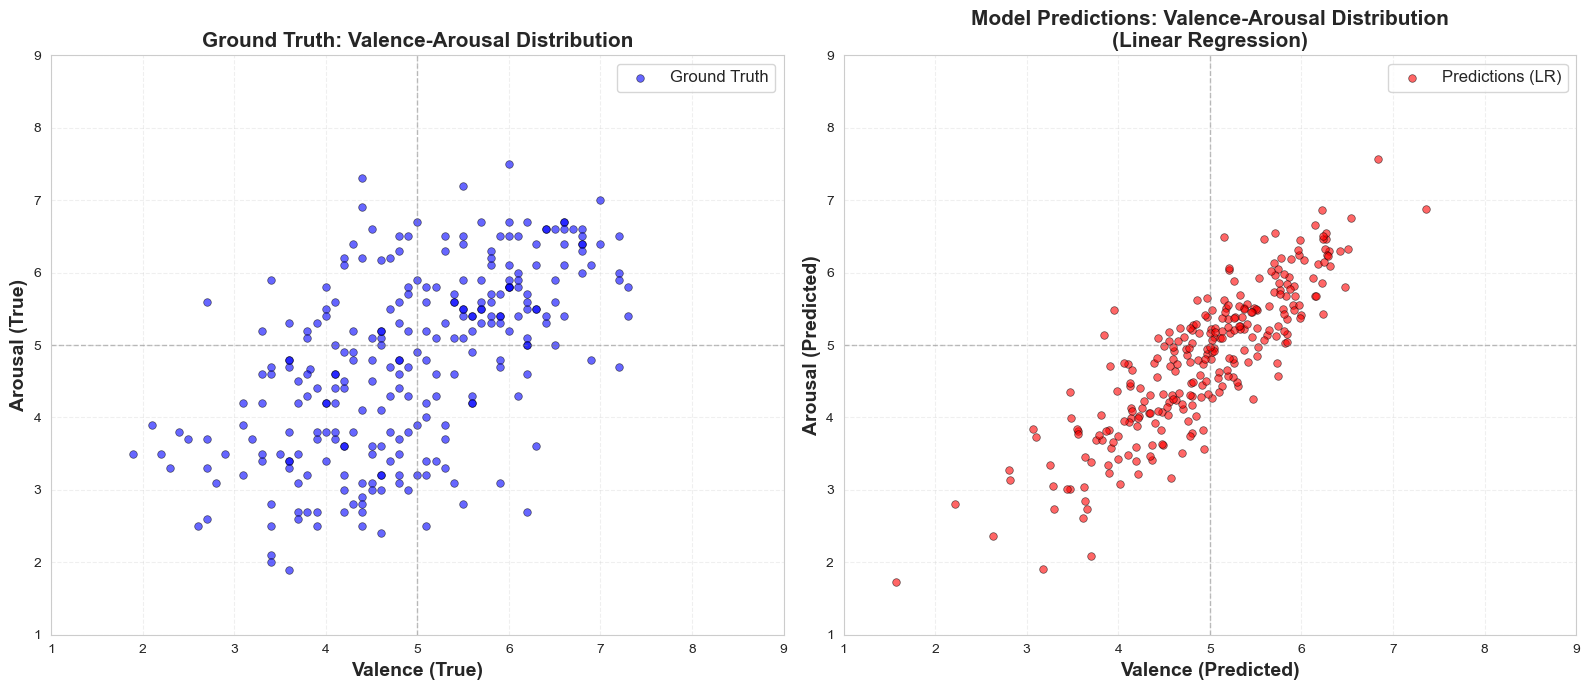

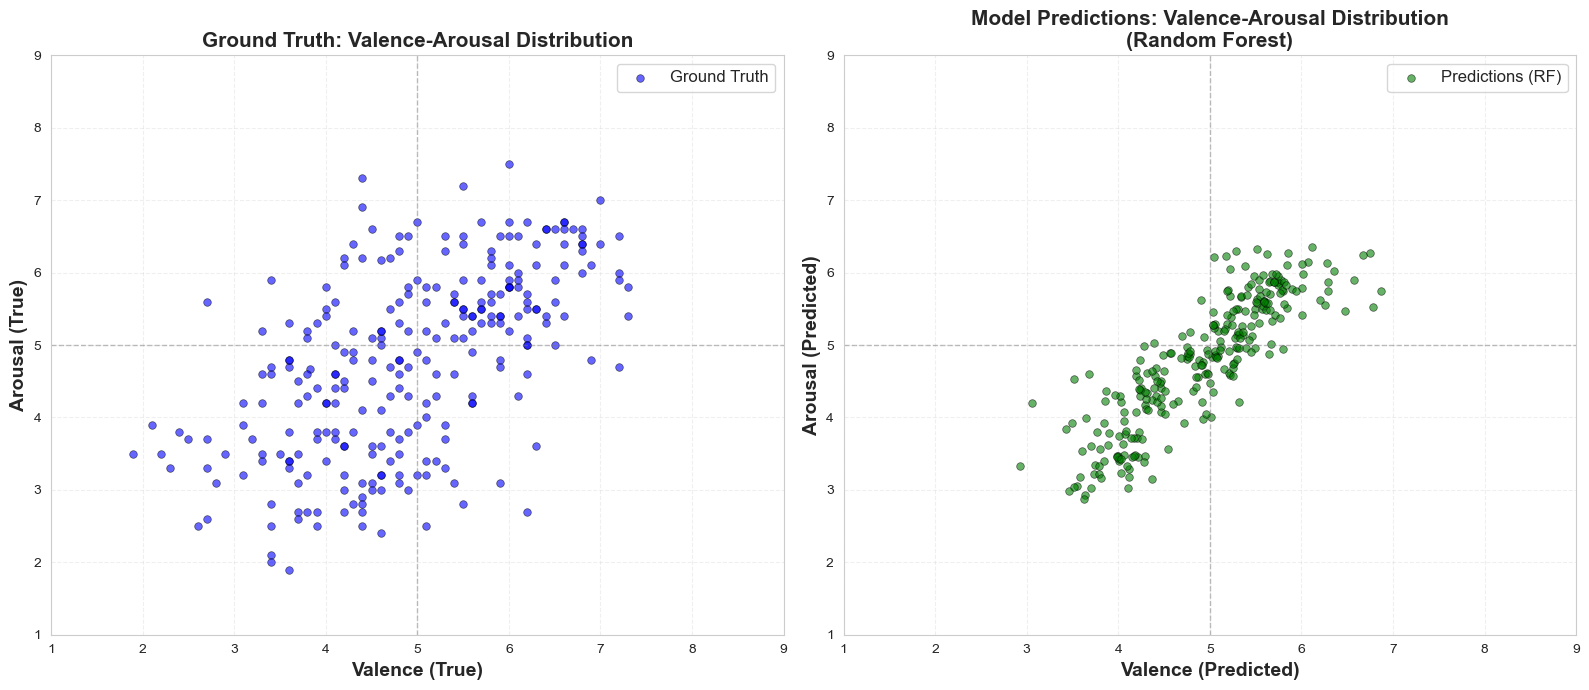

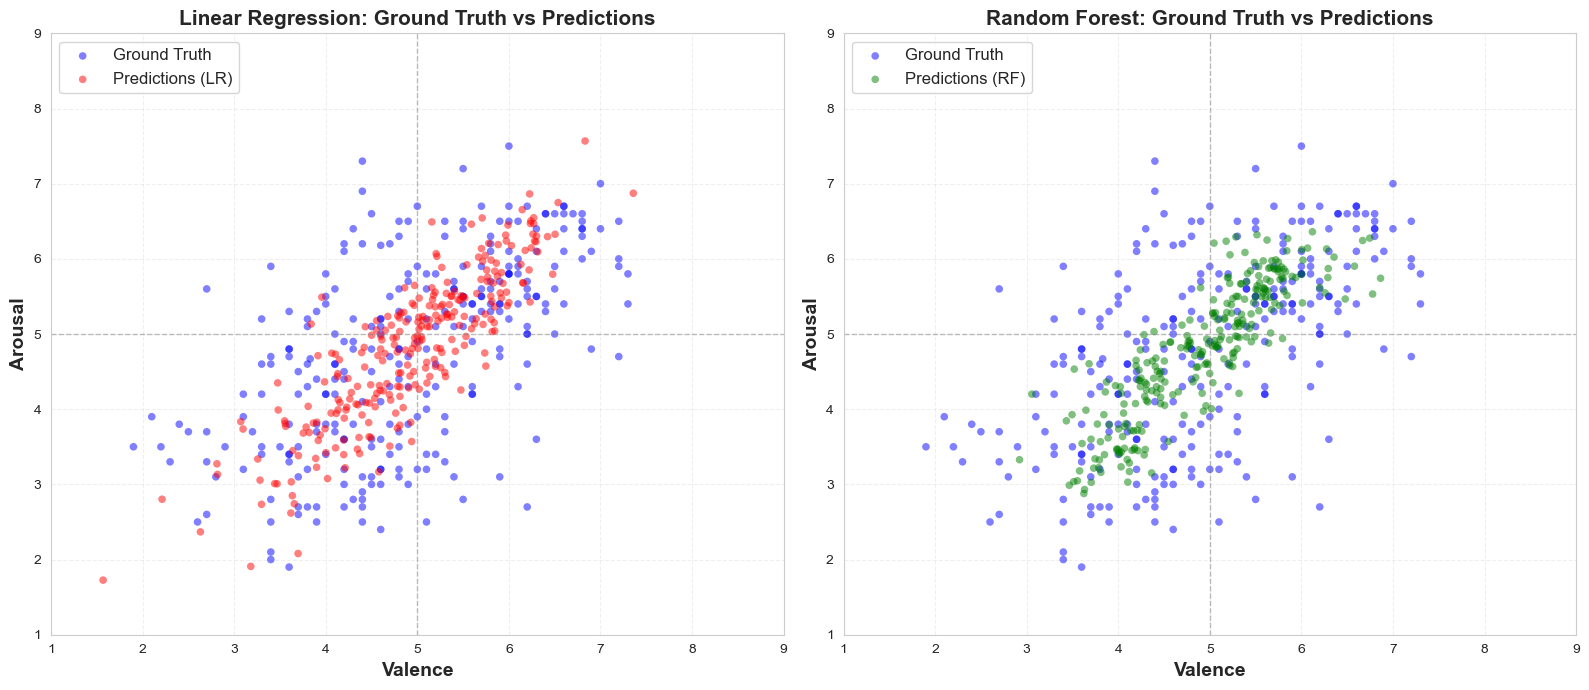


Valence-Arousal 2D Space Analysis
Generated 3 plots:
   1. Linear Regression: Ground Truth vs Predictions (Side-by-side)
   2. Random Forest: Ground Truth vs Predictions (Side-by-side)
   3. Overlay: Ground Truth vs Predictions (Both models overlaid)

How to detect Shortcutting:
   • If predictions concentrate on a diagonal or specific region → Possible shortcutting
   • If predictions cover most of the true distribution → Good learning
   • If predictions are too concentrated (low variance) → Model may only predict mean


In [17]:
# Valence-Arousal 2D Space comparison (Linear Regression)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Ground Truth
axes[0].scatter(data_selected['y_val_val'], data_selected['y_aro_val'], 
                alpha=0.6, s=30, c='blue', edgecolors='black', linewidths=0.5, label='Ground Truth')
axes[0].set_xlabel('Valence (True)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Arousal (True)', fontsize=14, fontweight='bold')
axes[0].set_title('Ground Truth: Valence-Arousal Distribution', fontsize=15, fontweight='bold')
axes[0].set_xlim(1, 9)
axes[0].set_ylim(1, 9)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(fontsize=12)
axes[0].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Right: Predictions
axes[1].scatter(lr_val_val_pred, lr_aro_val_pred, 
                alpha=0.6, s=30, c='red', edgecolors='black', linewidths=0.5, label='Predictions (LR)')
axes[1].set_xlabel('Valence (Predicted)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Arousal (Predicted)', fontsize=14, fontweight='bold')
axes[1].set_title('Model Predictions: Valence-Arousal Distribution\n(Linear Regression)', fontsize=15, fontweight='bold')
axes[1].set_xlim(1, 9)
axes[1].set_ylim(1, 9)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(fontsize=12)
axes[1].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'valence_arousal_2d_space_lr.png', dpi=150, bbox_inches='tight')
plt.show()

# Valence-Arousal 2D Space comparison (Random Forest)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Ground Truth
axes[0].scatter(data_all['y_val_val'], data_all['y_aro_val'], 
                alpha=0.6, s=30, c='blue', edgecolors='black', linewidths=0.5, label='Ground Truth')
axes[0].set_xlabel('Valence (True)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Arousal (True)', fontsize=14, fontweight='bold')
axes[0].set_title('Ground Truth: Valence-Arousal Distribution', fontsize=15, fontweight='bold')
axes[0].set_xlim(1, 9)
axes[0].set_ylim(1, 9)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(fontsize=12)
axes[0].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Right: Predictions
axes[1].scatter(rf_val_val_pred, rf_aro_val_pred, 
                alpha=0.6, s=30, c='green', edgecolors='black', linewidths=0.5, label='Predictions (RF)')
axes[1].set_xlabel('Valence (Predicted)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Arousal (Predicted)', fontsize=14, fontweight='bold')
axes[1].set_title('Model Predictions: Valence-Arousal Distribution\n(Random Forest)', fontsize=15, fontweight='bold')
axes[1].set_xlim(1, 9)
axes[1].set_ylim(1, 9)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(fontsize=12)
axes[1].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'valence_arousal_2d_space_rf.png', dpi=150, bbox_inches='tight')
plt.show()

# Overlay comparison (Ground Truth vs Predictions)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Linear Regression overlay
axes[0].scatter(data_selected['y_val_val'], data_selected['y_aro_val'], 
                alpha=0.5, s=30, c='blue', edgecolors='none', label='Ground Truth')
axes[0].scatter(lr_val_val_pred, lr_aro_val_pred, 
                alpha=0.5, s=30, c='red', edgecolors='none', label='Predictions (LR)')
axes[0].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[0].set_title('Linear Regression: Ground Truth vs Predictions', fontsize=15, fontweight='bold')
axes[0].set_xlim(1, 9)
axes[0].set_ylim(1, 9)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(fontsize=12, loc='upper left')
axes[0].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Right: Random Forest overlay
axes[1].scatter(data_all['y_val_val'], data_all['y_aro_val'], 
                alpha=0.5, s=30, c='blue', edgecolors='none', label='Ground Truth')
axes[1].scatter(rf_val_val_pred, rf_aro_val_pred, 
                alpha=0.5, s=30, c='green', edgecolors='none', label='Predictions (RF)')
axes[1].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[1].set_title('Random Forest: Ground Truth vs Predictions', fontsize=15, fontweight='bold')
axes[1].set_xlim(1, 9)
axes[1].set_ylim(1, 9)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(fontsize=12, loc='upper left')
axes[1].axhline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'valence_arousal_2d_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("Valence-Arousal 2D Space Analysis")
print("=" * 80)
print("Generated 3 plots:")
print("   1. Linear Regression: Ground Truth vs Predictions (Side-by-side)")
print("   2. Random Forest: Ground Truth vs Predictions (Side-by-side)")
print("   3. Overlay: Ground Truth vs Predictions (Both models overlaid)")
print("\nHow to detect Shortcutting:")
print("   • If predictions concentrate on a diagonal or specific region → Possible shortcutting")
print("   • If predictions cover most of the true distribution → Good learning")
print("   • If predictions are too concentrated (low variance) → Model may only predict mean")
print("=" * 80)


## 9. Feature Importance Analysis

### Random Forest Advantage

Random Forest can tell us which features are most important through the `feature_importances_` attribute.

### Interpretation
- Importance = average contribution of feature to reducing impurity
- Higher value = more important feature
- Sum = 1.0


In [18]:
# Get feature importances
val_importances = pd.DataFrame({
    'feature': feature_names_all,
    'importance': rf_valence.feature_importances_
}).sort_values('importance', ascending=False)

aro_importances = pd.DataFrame({
    'feature': feature_names_all,
    'importance': rf_arousal.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 60)
print("Feature Importance Analysis (Random Forest)")
print("=" * 60)

print("\nValence - TOP 10 Important Features:")
print("-" * 60)
for idx, row in val_importances.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:35s} {row['importance']:.6f}")

print("\nArousal - TOP 10 Important Features:")
print("-" * 60)
for idx, row in aro_importances.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:35s} {row['importance']:.6f}")


Feature Importance Analysis (Random Forest)

Valence - TOP 10 Important Features:
------------------------------------------------------------
  111. spectral_rolloff_mean               0.232860
   1. mfcc_mean_0                         0.113420
  133. beat_strength                       0.040321
  109. spectral_centroid_mean              0.033162
  114. spectral_contrast_mean_1            0.031906
  132. beat_count                          0.015377
  86. chroma_cqt_mean_1                   0.013081
  87. chroma_cqt_mean_2                   0.010916
  42. mfcc_delta_mean_1                   0.009561
  115. spectral_contrast_mean_2            0.009402

Arousal - TOP 10 Important Features:
------------------------------------------------------------
   1. mfcc_mean_0                         0.328868
  133. beat_strength                       0.072404
  109. spectral_centroid_mean              0.052419
  129. zcr_mean                            0.016965
  41. mfcc_delta_mean_0            

### 9.1 Visualize Feature Importance


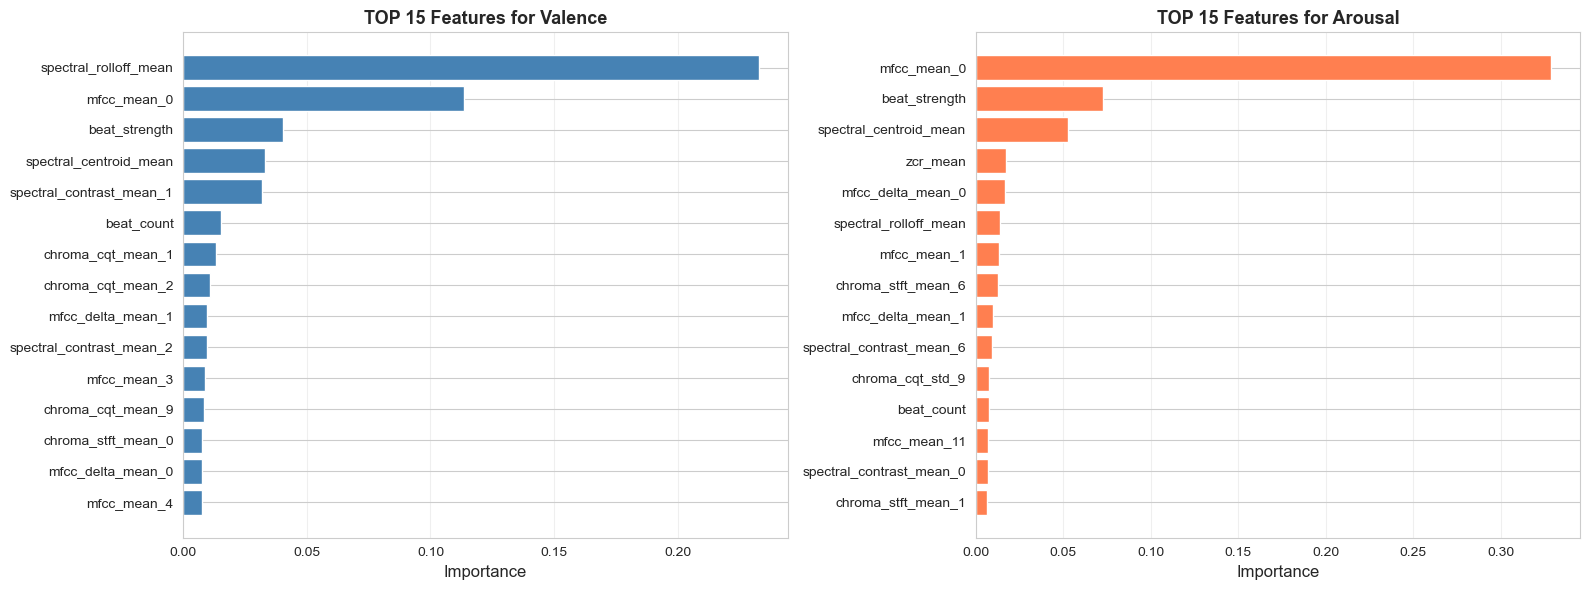

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valence
top_val = val_importances.head(15)
axes[0].barh(range(len(top_val)), top_val['importance'], color='steelblue')
axes[0].set_yticks(range(len(top_val)))
axes[0].set_yticklabels(top_val['feature'], fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('TOP 15 Features for Valence', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Arousal
top_aro = aro_importances.head(15)
axes[1].barh(range(len(top_aro)), top_aro['importance'], color='coral')
axes[1].set_yticks(range(len(top_aro)))
axes[1].set_yticklabels(top_aro['feature'], fontsize=10)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('TOP 15 Features for Arousal', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


## 10. Day 4-5 Summary


In [20]:
print("=" * 70)
print("Week 2 Day 4-5 Summary")
print("=" * 70)

print("\nCompleted tasks:")
print("  Day 4: Data preprocessing and standardization")
print("  Day 4: Data splitting (70% / 15% / 15%)")
print("  Day 4: Feature selection strategy")
print("  Day 4: Linear Regression training")
print("  Day 4: Random Forest training")
print("  Day 5: Model evaluation and comparison")
print("  Day 5: Prediction visualization")
print("  Day 5: Feature importance analysis")

print("\nModel Performance Summary (Validation Set):")
print("\n  Linear Regression:")
print(f"    • Valence:  R² = {lr_val_results[1]['R²']:.4f}, RMSE = {lr_val_results[1]['RMSE']:.4f}")
print(f"    • Arousal:  R² = {lr_aro_results[1]['R²']:.4f}, RMSE = {lr_aro_results[1]['RMSE']:.4f}")
print(f"    • Features: {X_selected.shape[1]}")

print("\n  Random Forest:")
print(f"    • Valence:  R² = {rf_val_results[1]['R²']:.4f}, RMSE = {rf_val_results[1]['RMSE']:.4f}")
print(f"    • Arousal:  R² = {rf_aro_results[1]['R²']:.4f}, RMSE = {rf_aro_results[1]['RMSE']:.4f}")
print(f"    • Features: {X_all.shape[1]}")

print("\nKey findings:")
valence_df = comparison_df[comparison_df['Target'] == 'Valence']
arousal_df = comparison_df[comparison_df['Target'] == 'Arousal']
better_val_model = valence_df.loc[valence_df['Val R²'].idxmax(), 'Model']
better_aro_model = arousal_df.loc[arousal_df['Val R²'].idxmax(), 'Model']
print(f"  1. {better_val_model} performs better on Valence")
print(f"  2. {better_aro_model} performs better on Arousal")
print(f"  3. Top feature for Valence: {val_importances.iloc[0]['feature']}")
print(f"  4. Top feature for Arousal: {aro_importances.iloc[0]['feature']}")

print("\nOutput files:")
print(f"  • models/prediction_scatter.png")
print(f"  • models/residuals_distribution.png")
print(f"  • models/feature_importance.png")
print(f"  • models/valence_arousal_2d_space_lr.png")
print(f"  • models/valence_arousal_2d_space_rf.png")
print(f"  • models/valence_arousal_2d_overlay.png")

print("\nNext steps (Week 3):")
print("  → Hyperparameter tuning (Grid/Random Search)")
print("  → Try more models (XGBoost, SVR)")
print("  → Feature engineering (polynomial features)")
print("  → Model ensembling")
print("  → Final evaluation on test set")

print("\n" + "=" * 70)
print("Baseline model training completed!")
print("=" * 70)


Week 2 Day 4-5 Summary

Completed tasks:
  Day 4: Data preprocessing and standardization
  Day 4: Data splitting (70% / 15% / 15%)
  Day 4: Feature selection strategy
  Day 4: Linear Regression training
  Day 4: Random Forest training
  Day 5: Model evaluation and comparison
  Day 5: Prediction visualization
  Day 5: Feature importance analysis

Model Performance Summary (Validation Set):

  Linear Regression:
    • Valence:  R² = 0.4580, RMSE = 0.8521
    • Arousal:  R² = 0.4985, RMSE = 0.8896
    • Features: 129

  Random Forest:
    • Valence:  R² = 0.4887, RMSE = 0.8276
    • Arousal:  R² = 0.5309, RMSE = 0.8604
    • Features: 133

Key findings:
  1. Random Forest performs better on Valence
  2. Random Forest performs better on Arousal
  3. Top feature for Valence: spectral_rolloff_mean
  4. Top feature for Arousal: mfcc_mean_0

Output files:
  • models/prediction_scatter.png
  • models/residuals_distribution.png
  • models/feature_importance.png
  • models/valence_arousal_2d_spac